# 🔍 Azure AI Custom Vision for Object Detection
# Part 2: End to end demo

<img src="https://connectoricons-prod.azureedge.net/releases/v1.0.1549/1.0.1549.2680/cognitiveservicescustomvision/icon.png">

**Azure AI Custom Vision** is a cloud-based computer vision service from Microsoft that enables developers to build **custom object detection models without requiring deep machine learning expertise**. It's part of Microsoft's Azure Cognitive Services suite and provides a user-friendly approach to training AI models for specific visual recognition tasks.

## ✨ Key Features
- 🎯 **Easy Model Training**: Custom Vision uses a web-based interface where users can upload and label training images. The service handles the underlying machine learning complexities, making it accessible to developers without extensive AI backgrounds.
- 📍 **Object Detection Capabilities**: The service can identify and locate multiple objects within a single image, providing bounding box coordinates for each detected item. This goes beyond simple image classification by pinpointing exactly where objects appear in the image.
- 🎨 **Custom Domain Focus**: Unlike general-purpose vision APIs, Custom Vision allows you to train models on your specific use cases, whether that's detecting manufacturing defects, identifying wildlife species, or recognizing retail products.

## ⚙️ How It Works

- **The training process** involves uploading labeled images to teach the model what to look for. You draw bounding boxes around objects of interest and assign tags to create training data. The service then uses transfer learning techniques to adapt pre-trained neural networks to your specific domain.
- 📊 **Performance Optimization**: The platform provides metrics like precision and recall to help evaluate model performance, and supports iterative improvement through additional training data and model refinement.
- 🚀 **Deployment Options**: Trained models can be consumed via REST APIs for cloud-based inference, or exported to run locally on edge devices including mobile platforms and IoT devices.

## 💼 Common Applications
Custom Vision object detection is particularly valuable for industrial inspection, retail inventory management, medical imaging analysis, agricultural monitoring, and security surveillance applications where standard vision APIs may not provide the specialized recognition capabilities needed.
The service integrates well with other Azure services and supports various programming languages through SDKs, making it a practical choice for organizations already using Microsoft's cloud ecosystem.

## 📄 Documentation
- https://www.customvision.ai/projects
- https://learn.microsoft.com/en-us/azure/ai-services/Custom-Vision-Service/overview
- https://learn.microsoft.com/en-us/azure/ai-services/custom-vision-service/get-started-build-detector

In [1]:
import cv2
import glob
import gradio as gr
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import time

from azure_cv_object_detection import (compare_iterations, create_regions_for_image, export_metrics_to_json, 
get_iteration_performance, get_predictions, get_project_id_by_name, get_specific_project_info, get_tag_statistics, 
normalize_bbox_coordinates, model_training, upload_image_batch, upload_images_to_azure_custom_vision)

from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from datetime import datetime, timedelta
from decimal import Decimal
from dotenv import load_dotenv
from IPython.display import display, FileLink
from msrest.authentication import ApiKeyCredentials
from pathlib import Path
from PIL import Image
from pylabel import importer
from typing import List, Tuple, Optional

In [2]:
sys.version

'3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]'

In [3]:
print(f"Today is {datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 08-Oct-2025 07:23:47


## 1. Settings

In [4]:
load_dotenv("azure.env")

# Training endpoint for Azure AI Custom Vision
training_endpoint = os.environ["training_endpoint"]
# Prediction endpoint for Azure AI Custom Vision
prediction_endpoint = os.environ["prediction_endpoint"]
# Training key for Azure AI Custom Vision
training_key = os.environ["training_key"]
# Prediction key for Azure AI Custom Vision
prediction_key = os.environ["prediction_key"]
# Prediction resource id
prediction_resource_id = os.environ["prediction_resource_id"]

In [5]:
# Azure AI Custom Vision training client
training_credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(training_endpoint, training_credentials)

# Azure AI Custom Vision prediction client
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(prediction_endpoint, prediction_credentials)

In [6]:
project_name = "swimming-pool-detection-2025"  # Azure AI Custom Vision project name
project_description = "Swimming pool object detection use-case"  # Azure AI Custom Vision description
publish_iteration_name = "pool_detection_model"  # Name of the deployed model

In [7]:
# Dir to store some results
RESULTS_DIR = "results"

os.makedirs(RESULTS_DIR, exist_ok=True)

In [8]:
# Existing dirs with some tests images
TEST_DIR = "test"
BATCH_DIR = "batch"

In [9]:
TRAIN_DIR = "images/train"

IMAGES_DIR = os.path.join(TRAIN_DIR, "png")
LABELS_DIR = os.path.join(TRAIN_DIR, "labels")

## 2. Import existing VOC annotations 

### We are going to use pylabel for importing the VOC annotated files

In [10]:
start = time.time()

dataset = importer.ImportVOC(path=LABELS_DIR,
                             path_to_images="../png/",
                             name="swimmingpool")

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print(f"✅ Done. Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Importing VOC files...: 100%|██████████| 1224/1224 [00:18<00:00, 64.89it/s]

✅ Done. Elapsed time = 0 minutes and 19 seconds


In [11]:
print(f"Total number of images: {dataset.analyze.num_images}")

Total number of images: 1224


### Generating two samples from the initial images dataset

In [12]:
nb_images = 100

# Get all unique image IDs
all_img_ids = dataset.df['img_id'].unique()
print(f"Number of unique image IDs: {len(all_img_ids)}")

# Subsets
subset1 = all_img_ids[:nb_images]  # The first images
subset2 = all_img_ids[nb_images:]  # The rest of the images
dataset1_df = dataset.df[dataset.df['img_id'].isin(subset1)].copy()
dataset2_df = dataset.df[dataset.df['img_id'].isin(subset2)].copy()

dataset1 = importer.ImportVOC(path=LABELS_DIR,
                              path_to_images="../png/",
                              name="swimmingpool_subset1")
dataset1.df = dataset1_df

dataset2 = importer.ImportVOC(path=LABELS_DIR,
                              path_to_images="../png/",
                              name="swimmingpool_subset2")
dataset2.df = dataset2_df

print(f"Number of images in dataset1 = {dataset1.analyze.num_images}")
print(f"Number of images in dataset2 = {dataset2.analyze.num_images}")

Number of unique image IDs: 1224


Importing VOC files...: 100%|██████████| 1224/1224 [00:15<00:00, 79.94it/s]

Number of images in dataset1 = 100
Number of images in dataset2 = 1124


> Dataset1 contains the first 100 images. Dataset2 contains the rest.

### Let's display some images using an index or a filename

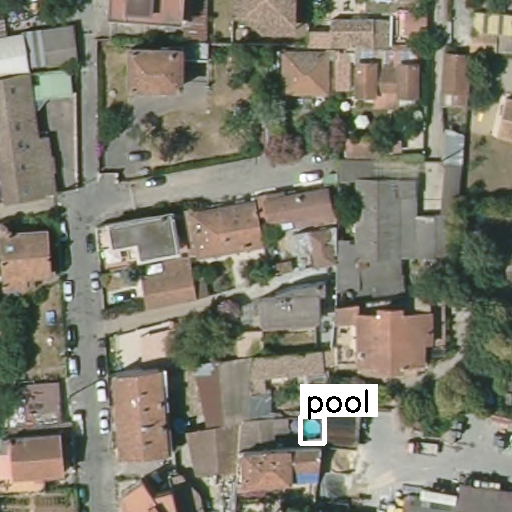

In [13]:
display(dataset1.visualize.ShowBoundingBoxes(10))

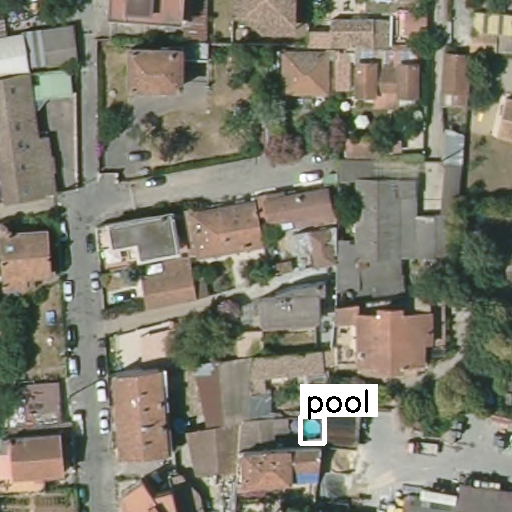

In [14]:
display(dataset1.visualize.ShowBoundingBoxes(10))

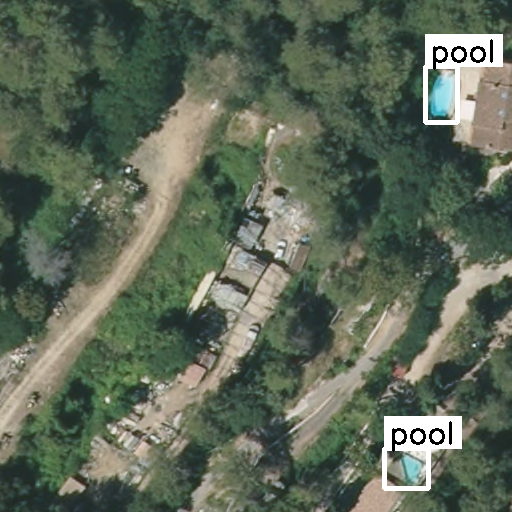

In [15]:
display(dataset1.visualize.ShowBoundingBoxes(20))

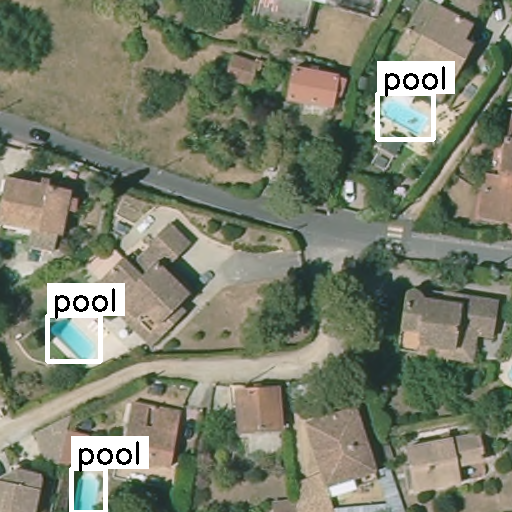

In [16]:
# or using filename
display(dataset.visualize.ShowBoundingBoxes("CANNES_TILES_512x512.618.png"))

## Analyze annotations
Pylabel can calculate basic summary statisticts about the dataset such as the number of files and the classes. 
The dataset is stored as a pandas frame so the developer can do additional exploratory analysis on the dataset. 

In [17]:
df = dataset.df
df

img_folder                   img_filename img_path  img_id  img_width  \
id                                                                           
0       ../png/    CANNES_TILES_512x512.10.png      NaN       0        512   
1       ../png/    CANNES_TILES_512x512.10.png      NaN       0        512   
2       ../png/  CANNES_TILES_512x512.1000.png      NaN       1        512   
3       ../png/  CANNES_TILES_512x512.1000.png      NaN       1        512   
4       ../png/  CANNES_TILES_512x512.1001.png      NaN       2        512   
...         ...                            ...      ...     ...        ...   
3192    ../png/   CANNES_TILES_512x512.997.png      NaN    1222        512   
3193    ../png/   CANNES_TILES_512x512.997.png      NaN    1222        512   
3194    ../png/   CANNES_TILES_512x512.997.png      NaN    1222        512   
3195    ../png/   CANNES_TILES_512x512.997.png      NaN    1222        512   
3196    ../png/   CANNES_TILES_512x512.998.png      NaN    1223        512   

      img_height img_depth ann_segmented  ann_bbox_xmin  ann_bbox_ymin  ...  \
id                                                                      ...   
0            512         3             0          204.0          326.0  ...   
1            512         3             0          197.0          347.0  ...   
2            512         3             0          315.0          140.0  ...   
3            512         3             0            1.0          317.0  ...   
4            512         3             0           95.0          246.0  ...   
...          ...       ...           ...            ...            ...  ...   
3192         512         3             0          137.0          266.0  ...   
3193         512         3             0          160.0           79.0  ...   
3194         512         3             0          457.0          303.0  ...   
3195         512         3             0          465.0          477.0  ...   
3196         512         3             0          171.0          227.0  ...   

      ann_iscrowd  ann_keypoints     ann_pose  ann_truncated  ann_difficult  \
id                                                                            
0             NaN            NaN  Unspecified              0              0   
1             NaN            NaN  Unspecified              0              0   
2             NaN            NaN  Unspecified              0              0   
3             NaN            NaN  Unspecified              1              0   
4             NaN            NaN  Unspecified              0              0   
...           ...            ...          ...            ...            ...   
3192          NaN            NaN  Unspecified              0              0   
3193          NaN            NaN  Unspecified              0              0   
3194          NaN            NaN  Unspecified              0              0   
3195          NaN            NaN  Unspecified              1              0   
3196          NaN            NaN  Unspecified              0              0   

     cat_id cat_name cat_supercategory split annotated  
id                                                      
0         0     pool               NaN               1  
1         0     pool               NaN               1  
2         0     pool               NaN               1  
3         0     pool               NaN               1  
4         0     pool               NaN               1  
...     ...      ...               ...   ...       ...  
3192      0     pool               NaN               1  
3193      0     pool               NaN               1  
3194      0     pool               NaN               1  
3195      0     pool               NaN               1  
3196      0     pool               NaN               1  

[3197 rows x 26 columns]

In [18]:
nb_pools = df['split'].value_counts()
print("Number of swimming pools")
print(nb_pools)

Number of swimming pools
split
    3197
Name: count, dtype: int64


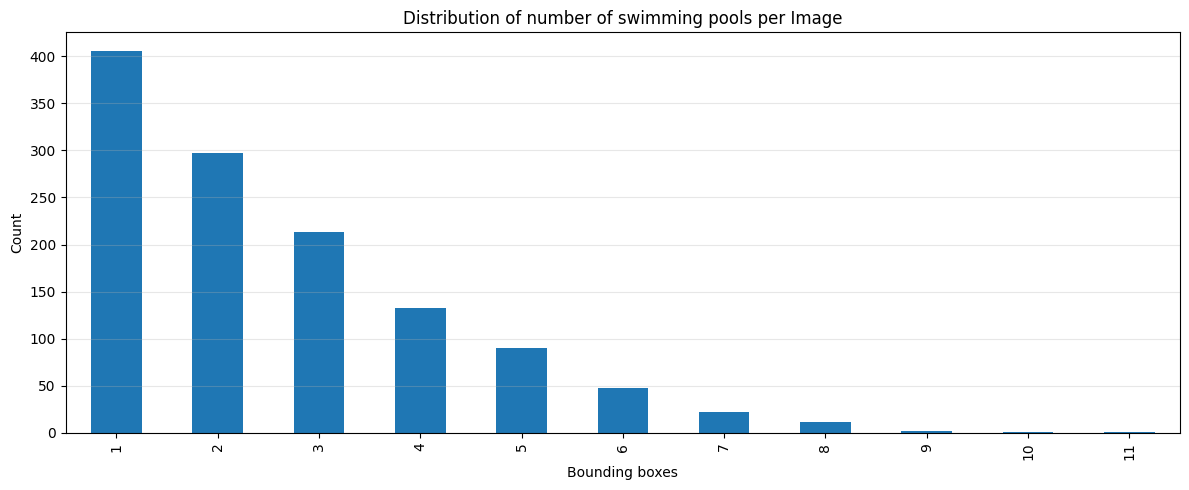

In [19]:
boxes_per_image = df.groupby('img_id').size()

plt.figure(figsize=(12, 5))
boxes_per_image.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Bounding boxes')
plt.ylabel('Count')
plt.title('Distribution of number of swimming pools per Image')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
print("Statistics of boxes per image:\n")
print(boxes_per_image.describe())
print(f"\nImages with 1 box = {(boxes_per_image == 1).sum()}")
print(f"Images with 2 boxes = {(boxes_per_image == 2).sum()}")
print(f"Images with 3+ boxes = {(boxes_per_image >= 3).sum()}")

Statistics of boxes per image:

count    1224.000000
mean        2.611928
std         1.690400
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        11.000000
dtype: float64

Images with 1 box = 405
Images with 2 boxes = 297
Images with 3+ boxes = 522


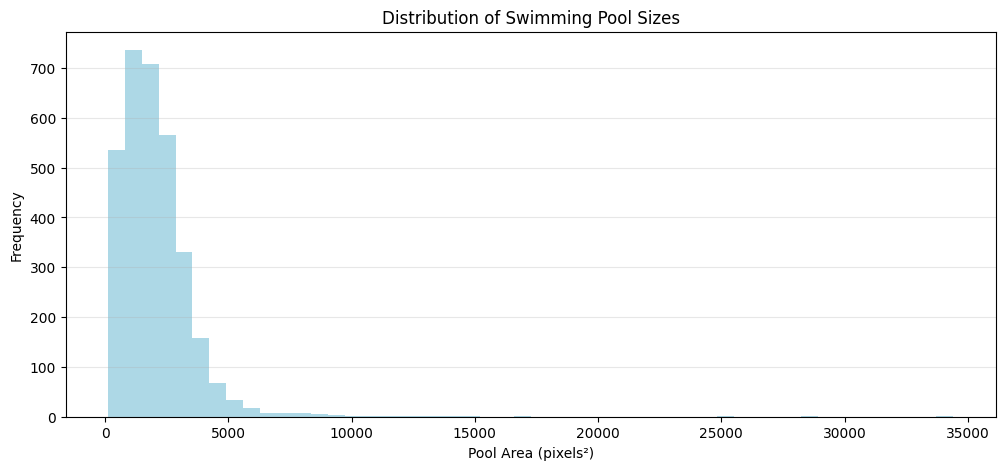

In [21]:
plt.figure(figsize=(12, 5))
plt.hist(df['ann_area'].dropna(), bins=50, color="lightblue")
plt.xlabel('Pool Area (pixels²)')
plt.ylabel('Frequency')
plt.title('Distribution of Swimming Pool Sizes')
plt.grid(axis='y', alpha=0.3)
plt.show()

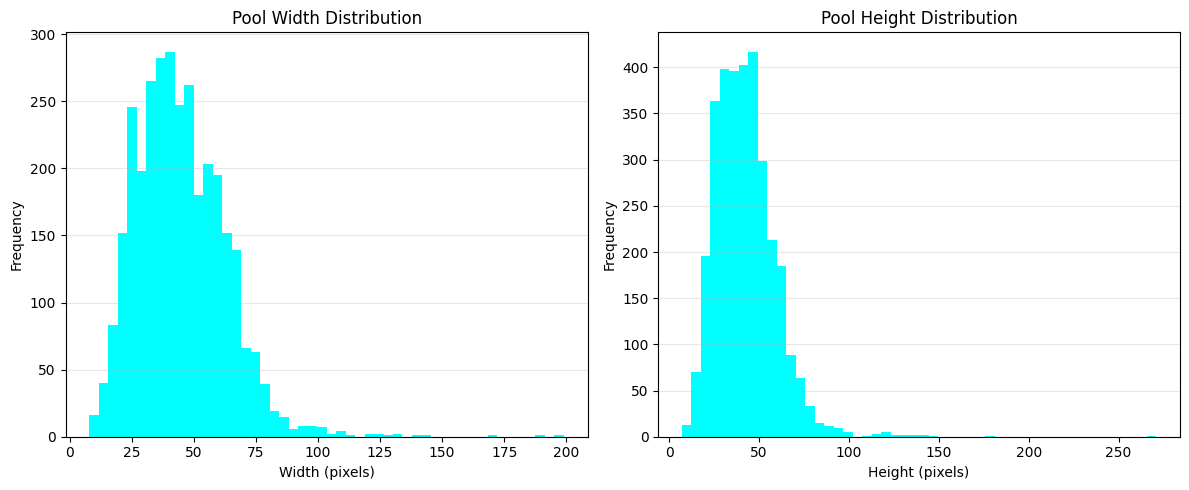

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].grid(axis='y', alpha=0.3)
axes[0].hist(df['ann_bbox_width'].dropna(), bins=50, color="cyan")
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Pool Width Distribution')

axes[1].hist(df['ann_bbox_height'].dropna(), bins=50, color="cyan")
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Pool Height Distribution')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
print(f"Total number of pools: {len(df)}")
print(f"Annotated pools: {df['annotated'].sum()}")
print(f"\nArea statistics:")
print(df['ann_area'].describe())

Total number of pools: 3197
Annotated pools: 3197

Area statistics:
count     3197.000000
mean      2043.280888
std       1647.162186
min        110.000000
25%       1035.000000
50%       1786.000000
75%       2632.000000
max      34417.000000
Name: ann_area, dtype: float64


In [24]:
print(f"Number of images = {dataset.analyze.num_images}")

Number of images = 1224


In [25]:
print(f"Number of classes = {dataset.analyze.num_classes}")
print(f"Classes:{dataset.analyze.classes}")

Number of classes = 1
Classes:['pool']


In [26]:
print(f"Class counts=\n{dataset.analyze.class_counts}")

Class counts=
cat_name
pool    3197
Name: count, dtype: int64


## 3. Creating Azure AI Custom Vision project

In [27]:
print(f"📘 Creation of Azure Custom Vision project: {project_name}")

obj_detection_domain = next(domain for domain in trainer.get_domains() \
                            if domain.type == "ObjectDetection" and domain.name == "General [A1]")

project = trainer.create_project(project_name,
                                 domain_id=obj_detection_domain.id,
                                 description=project_description)
print("✅ Done")

📘 Creation of Azure Custom Vision project: swimming-pool-detection-2025
✅ Done


## 4. Creating tags

In [28]:
print(f"🏷️ Number of tags = {len(dataset.analyze.classes)}")

🏷️ Number of tags = 1


In [29]:
print(dataset.analyze.classes)

['pool']


In [30]:
tags = {}

print("🏷️ Creating tag")
for class_name in dataset.analyze.classes:
    tag = trainer.create_tag(project.id, class_name)
    tags[class_name] = tag
print("✅ Done")

🏷️ Creating tag
✅ Done


## 5. Uploading images and labels

In [31]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

### Uploading the first 100 images

In [32]:
success, fail = upload_images_to_azure_custom_vision(
    dataset=dataset1,  # the 100 images
    trainer=trainer,
    project=project,
    tags=tags,
    project_name=project_name,
    batch_size=64,  # 64 images per batch is the max value for Azure AI Custom Vision.
)

2025-10-08 07:25:43,933 - INFO - Starting upload of 100 images to Azure Custom Vision project: 'swimming-pool-detection-2025'
2025-10-08 07:25:44,385 - INFO - Progress: 10/100 images processed (10.0%)
2025-10-08 07:25:44,849 - INFO - Progress: 20/100 images processed (20.0%)
2025-10-08 07:25:45,426 - INFO - Progress: 30/100 images processed (30.0%)
2025-10-08 07:25:45,904 - INFO - Progress: 40/100 images processed (40.0%)
2025-10-08 07:25:46,443 - INFO - Progress: 50/100 images processed (50.0%)
2025-10-08 07:25:46,782 - INFO - Progress: 60/100 images processed (60.0%)
2025-10-08 07:25:51,285 - INFO - Successfully uploaded batch of 64 images (64/100 total)
2025-10-08 07:25:51,639 - INFO - Progress: 70/100 images processed (70.0%)
2025-10-08 07:25:52,105 - INFO - Progress: 80/100 images processed (80.0%)
2025-10-08 07:25:52,589 - INFO - Progress: 90/100 images processed (90.0%)
2025-10-08 07:25:54,680 - INFO - Successfully uploaded batch of 36 images (100/100 total)
2025-10-08 07:25:54,

In [33]:
print(f"✅ Number of images loaded = {success}\n❌ Number of failed images = {fail}")

✅ Number of images loaded = 100
❌ Number of failed images = 0


## 6. Azure AI Custom Vision project

In [34]:
project_id = get_project_id_by_name(project_name)
print(f"🆔 Project ID: {project_id}")

🆔 Project ID: 86ab7e3f-819c-4680-9a7d-6723f2778e71


In [35]:
get_specific_project_info(project_id)

🗂️ Project: swimming-pool-detection-2025
🆔 Project id: 86ab7e3f-819c-4680-9a7d-6723f2778e71
📊 Total iterations = 0


In [36]:
get_tag_statistics(project_id)

{'total_tags': 1,
 'tags_with_images': 1,
 'total_tagged_images': 100,
 'tag_details': [{'name': 'pool',
   'image_count': 100,
   'id': 'bb031dba-d252-4b72-9dac-f06835c00850'}]}

## 7. Model training

In [37]:
start = time.time()

iteration = model_training(project_id, display_interval=10)

elapsed = time.time() - start
h, r = divmod(elapsed, 3600)
m, s = divmod(r, 60)
print(f"Elapsed time = {int(h)} hours, {int(m)} minutes and {int(s)} seconds")

🧠 Starting 'Quick Training'

🎯 Training started. Iteration ID: 35937719-0be0-417c-b0d3-ab87b0edf0c2
⏳ Initial Status: Training

[08-Oct-2025 07:26:31] Current Status: Training | Elapsed time: 0 hours, 0 minutes, 10 seconds
[08-Oct-2025 07:26:41] Current Status: Training | Elapsed time: 0 hours, 0 minutes, 20 seconds
[08-Oct-2025 07:26:51] Current Status: Training | Elapsed time: 0 hours, 0 minutes, 30 seconds
[08-Oct-2025 07:27:01] Current Status: Training | Elapsed time: 0 hours, 0 minutes, 40 seconds
[08-Oct-2025 07:27:11] Current Status: Training | Elapsed time: 0 hours, 0 minutes, 50 seconds
[08-Oct-2025 07:27:21] Current Status: Training | Elapsed time: 0 hours, 1 minutes, 0 seconds
[08-Oct-2025 07:27:31] Current Status: Training | Elapsed time: 0 hours, 1 minutes, 11 seconds
[08-Oct-2025 07:27:41] Current Status: Training | Elapsed time: 0 hours, 1 minutes, 21 seconds
[08-Oct-2025 07:27:51] Current Status: Training | Elapsed time: 0 hours, 1 minutes, 31 seconds
[08-Oct-2025 07:28

## 8. Training informations

In [38]:
get_specific_project_info(project_id)

🗂️ Project: swimming-pool-detection-2025
🆔 Project id: 86ab7e3f-819c-4680-9a7d-6723f2778e71
📊 Total iterations = 1
  🌀 Iteration: Iteration 1
  ✅ Status: Completed
  📅 Created: 2025-10-08 07:25:39.140000+00:00


## 9. Model performance metrics

In [39]:
# Get all iterations
iterations = trainer.get_iterations(project_id)

for iteration in iterations:
    print(f"🆔 Iteration ID: {iteration.id}")
    print(f"🏷️ Name: {iteration.name}")
    print(f"📊 Status: {iteration.status}")

🆔 Iteration ID: 35937719-0be0-417c-b0d3-ab87b0edf0c2
🏷️ Name: Iteration 1
📊 Status: Completed


In [40]:
metrics = get_iteration_performance(trainer, project_id, iteration.id, threshold=0.5, overlap=0.3)
display(metrics)

📊 Retrieving performance metrics for iteration: 35937719-0be0-417c-b0d3-ab87b0edf0c2
📋 Iteration Name: Iteration 1
📅 Created: 2025-10-08 07:25:39.140000+00:00
🔄 Status: Completed
⚙️  Training Type: Regular

🏆 OVERALL PERFORMANCE METRICS
📈 Precision: 0.8085 (80.85%)
📈 Recall: 1.0000 (100.00%)
📈 Average Precision (AP): 0.9706 (97.06%)

🏷️  PER-TAG PERFORMANCE (Threshold: 0.5)
🏷️  Tag: pool
   📊 Precision: 0.8085 (80.85%)
   📊 Recall: 1.0000 (100.00%)
   📊 Average Precision: 0.9706 (97.06%)

💡 PERFORMANCE INTERPRETATION
Overall Rating: 🌟 Excellent (Score: 0.926)

💡 RECOMMENDATIONS


{'iteration_id': '35937719-0be0-417c-b0d3-ab87b0edf0c2',
 'iteration_name': 'Iteration 1',
 'status': 'Completed',
 'training_type': 'Regular',
 'created': datetime.datetime(2025, 10, 8, 7, 25, 39, 140000, tzinfo=<isodate.tzinfo.Utc object at 0x714238ea0ca0>),
 'threshold': 0.5,
 'overall_metrics': {'precision': 0.80851066,
  'recall': 1.0,
  'average_precision': 0.97062635,
  'overall_score': 0.9263790033333333},
 'per_tag_metrics': [{'tag_name': 'pool',
   'tag_id': 'bb031dba-d252-4b72-9dac-f06835c00850',
   'precision': 0.80851066,
   'recall': 1.0,
   'average_precision': 0.97062635}]}

In [41]:
export_metrics_to_json(metrics, os.path.join(RESULTS_DIR, "metrics1.json"))

📄 Metrics exported to: results/metrics1.json


'results/metrics1.json'

## 10. Uploading more images to the project

In [42]:
print(f"Number of images in subset2 = {dataset2.analyze.num_images}")

Number of images in subset2 = 1124


In [43]:
success, fail = upload_images_to_azure_custom_vision(
    dataset=dataset2,
    trainer=trainer,
    project=project,
    tags=tags,
    project_name=project_name,
    batch_size=64,  # 64 images per batch is the max value for Azure AI Custom Vision.
)

2025-10-08 07:52:08,890 - INFO - Starting upload of 1124 images to Azure Custom Vision project: 'swimming-pool-detection-2025'
2025-10-08 07:52:11,298 - INFO - Progress: 50/1124 images processed (4.4%)
2025-10-08 07:52:14,421 - INFO - Successfully uploaded batch of 64 images (64/1124 total)
2025-10-08 07:52:16,235 - INFO - Progress: 100/1124 images processed (8.9%)
2025-10-08 07:52:19,951 - INFO - Successfully uploaded batch of 64 images (128/1124 total)
2025-10-08 07:52:20,872 - INFO - Progress: 150/1124 images processed (13.3%)
2025-10-08 07:52:24,970 - INFO - Successfully uploaded batch of 64 images (192/1124 total)
2025-10-08 07:52:25,469 - INFO - Progress: 200/1124 images processed (17.8%)
2025-10-08 07:52:27,752 - INFO - Progress: 250/1124 images processed (22.2%)
2025-10-08 07:52:30,253 - INFO - Successfully uploaded batch of 64 images (256/1124 total)
2025-10-08 07:52:32,291 - INFO - Progress: 300/1124 images processed (26.7%)
2025-10-08 07:52:35,326 - INFO - Successfully uploa

In [44]:
get_tag_statistics(project_id)

{'total_tags': 1,
 'tags_with_images': 1,
 'total_tagged_images': 1224,
 'tag_details': [{'name': 'pool',
   'image_count': 1224,
   'id': 'bb031dba-d252-4b72-9dac-f06835c00850'}]}

> We have now 1224 images in our project

In [45]:
start = time.time()

iteration = model_training(project_id, display_interval=120)

elapsed = time.time() - start
h, r = divmod(elapsed, 3600)
m, s = divmod(r, 60)
print(f"Elapsed time = {int(h)} hours, {int(m)} minutes and {int(s)} seconds")

🧠 Starting 'Quick Training'

🎯 Training started. Iteration ID: 5e55c47c-d151-40d6-8ba2-02882bf838be
⏳ Initial Status: Training

[08-Oct-2025 07:55:56] Current Status: Training | Elapsed time: 0 hours, 2 minutes, 0 seconds
[08-Oct-2025 07:57:56] Current Status: Training | Elapsed time: 0 hours, 4 minutes, 0 seconds
[08-Oct-2025 07:59:56] Current Status: Training | Elapsed time: 0 hours, 6 minutes, 0 seconds
[08-Oct-2025 08:01:56] Current Status: Training | Elapsed time: 0 hours, 8 minutes, 1 seconds
[08-Oct-2025 08:03:56] Current Status: Training | Elapsed time: 0 hours, 10 minutes, 1 seconds
[08-Oct-2025 08:05:56] Current Status: Training | Elapsed time: 0 hours, 12 minutes, 1 seconds
[08-Oct-2025 08:07:56] Current Status: Training | Elapsed time: 0 hours, 14 minutes, 1 seconds
[08-Oct-2025 08:09:57] Current Status: Training | Elapsed time: 0 hours, 16 minutes, 1 seconds
[08-Oct-2025 08:11:57] Current Status: Training | Elapsed time: 0 hours, 18 minutes, 1 seconds
[08-Oct-2025 08:13:57

In [46]:
get_specific_project_info(project_id)

🗂️ Project: swimming-pool-detection-2025
🆔 Project id: 86ab7e3f-819c-4680-9a7d-6723f2778e71
📊 Total iterations = 2
  🌀 Iteration: Iteration 2
  ✅ Status: Completed
  📅 Created: 2025-10-08 07:26:21.743000+00:00
  🌀 Iteration: Iteration 1
  ✅ Status: Completed
  📅 Created: 2025-10-08 07:25:39.140000+00:00


In [47]:
metrics = get_iteration_performance(trainer, project_id, iteration.id, threshold=0.5, overlap=0.3)
display(metrics)

📊 Retrieving performance metrics for iteration: 5e55c47c-d151-40d6-8ba2-02882bf838be
📋 Iteration Name: Iteration 2
📅 Created: 2025-10-08 07:26:21.743000+00:00
🔄 Status: Completed
⚙️  Training Type: Regular

🏆 OVERALL PERFORMANCE METRICS
📈 Precision: 0.8337 (83.37%)
📈 Recall: 0.9812 (98.12%)
📈 Average Precision (AP): 0.9752 (97.52%)

🏷️  PER-TAG PERFORMANCE (Threshold: 0.5)
🏷️  Tag: pool
   📊 Precision: 0.8337 (83.37%)
   📊 Recall: 0.9812 (98.12%)
   📊 Average Precision: 0.9752 (97.52%)

💡 PERFORMANCE INTERPRETATION
Overall Rating: 🌟 Excellent (Score: 0.930)

💡 RECOMMENDATIONS


{'iteration_id': '5e55c47c-d151-40d6-8ba2-02882bf838be',
 'iteration_name': 'Iteration 2',
 'status': 'Completed',
 'training_type': 'Regular',
 'created': datetime.datetime(2025, 10, 8, 7, 26, 21, 743000, tzinfo=<isodate.tzinfo.Utc object at 0x714238ea0ca0>),
 'threshold': 0.5,
 'overall_metrics': {'precision': 0.8337439,
  'recall': 0.98115945,
  'average_precision': 0.9751611,
  'overall_score': 0.9300214833333333},
 'per_tag_metrics': [{'tag_name': 'pool',
   'tag_id': 'bb031dba-d252-4b72-9dac-f06835c00850',
   'precision': 0.8337439,
   'recall': 0.98115945,
   'average_precision': 0.9751611}]}

In [48]:
export_metrics_to_json(metrics, os.path.join(RESULTS_DIR, "metrics2.json"))

📄 Metrics exported to: results/metrics2.json


'results/metrics2.json'

## 11. Get All iterations

In [49]:
# Get all iterations
iterations = trainer.get_iterations(project_id)
iteration_ids_list = []

for iteration in iterations:
    print(f"🆔 Iteration ID: {iteration.id}")
    print(f"🏷️ Name: {iteration.name}")
    print(f"📊 Status: {iteration.status}")
    iteration_ids_list.append(iteration.id)

🆔 Iteration ID: 5e55c47c-d151-40d6-8ba2-02882bf838be
🏷️ Name: Iteration 2
📊 Status: Completed
🆔 Iteration ID: 35937719-0be0-417c-b0d3-ab87b0edf0c2
🏷️ Name: Iteration 1
📊 Status: Completed


## 12. Model performance metrics

In [50]:
with open(os.path.join(RESULTS_DIR, "metrics1.json"), 'r') as f:
    data1 = json.load(f)

with open(os.path.join(RESULTS_DIR, "metrics2.json"), 'r') as f:
    data2 = json.load(f)

df_metrics= pd.concat([pd.json_normalize(data1), pd.json_normalize(data2)], ignore_index=True)
df_metrics

iteration_id iteration_name     status  \
0  35937719-0be0-417c-b0d3-ab87b0edf0c2    Iteration 1  Completed   
1  5e55c47c-d151-40d6-8ba2-02882bf838be    Iteration 2  Completed   

  training_type                           created  threshold  \
0       Regular  2025-10-08 07:25:39.140000+00:00        0.5   
1       Regular  2025-10-08 07:26:21.743000+00:00        0.5   

                                     per_tag_metrics  \
0  [{'tag_name': 'pool', 'tag_id': 'bb031dba-d252...   
1  [{'tag_name': 'pool', 'tag_id': 'bb031dba-d252...   

   overall_metrics.precision  overall_metrics.recall  \
0                   0.808511                1.000000   
1                   0.833744                0.981159   

   overall_metrics.average_precision  overall_metrics.overall_score  
0                           0.970626                       0.926379  
1                           0.975161                       0.930021

In [51]:
metrics_file = os.path.join(RESULTS_DIR, "model_metrics.xlsx")
df_metrics.to_excel(metrics_file, index=False)

In [52]:
excel_link = FileLink(path=metrics_file)
excel_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Azure AI Custom Vision OD/results/model_metrics.xlsx

In [53]:
iteration_ids_list

['5e55c47c-d151-40d6-8ba2-02882bf838be',
 '35937719-0be0-417c-b0d3-ab87b0edf0c2']

In [54]:
comparison = compare_iterations(trainer, project_id, iteration_ids_list)

⚖️  COMPARING 2 ITERATIONS

📊 Iteration 1: 5e55c47c-d151-40d6-8ba2-02882bf838be
------------------------------
📊 Retrieving performance metrics for iteration: 5e55c47c-d151-40d6-8ba2-02882bf838be
📋 Iteration Name: Iteration 2
📅 Created: 2025-10-08 07:26:21.743000+00:00
🔄 Status: Completed
⚙️  Training Type: Regular

🏆 OVERALL PERFORMANCE METRICS
📈 Precision: 0.8337 (83.37%)
📈 Recall: 0.9812 (98.12%)
📈 Average Precision (AP): 0.9752 (97.52%)

🏷️  PER-TAG PERFORMANCE (Threshold: 0.5)
🏷️  Tag: pool
   📊 Precision: 0.8337 (83.37%)
   📊 Recall: 0.9812 (98.12%)
   📊 Average Precision: 0.9752 (97.52%)

💡 PERFORMANCE INTERPRETATION
Overall Rating: 🌟 Excellent (Score: 0.930)

💡 RECOMMENDATIONS

📊 Iteration 2: 35937719-0be0-417c-b0d3-ab87b0edf0c2
------------------------------
📊 Retrieving performance metrics for iteration: 35937719-0be0-417c-b0d3-ab87b0edf0c2
📋 Iteration Name: Iteration 1
📅 Created: 2025-10-08 07:25:39.140000+00:00
🔄 Status: Completed
⚙️  Training Type: Regular

🏆 OVERALL PERFO

## 13. Publishing the model

In [55]:
print(f"🚀 Deploying the model {publish_iteration_name} ...")
trainer.publish_iteration(project_id, iteration_ids_list[0], publish_iteration_name, prediction_resource_id)
print("✅ Done")

🚀 Deploying the model pool_detection_model ...
✅ Done


## 14. Testing the model

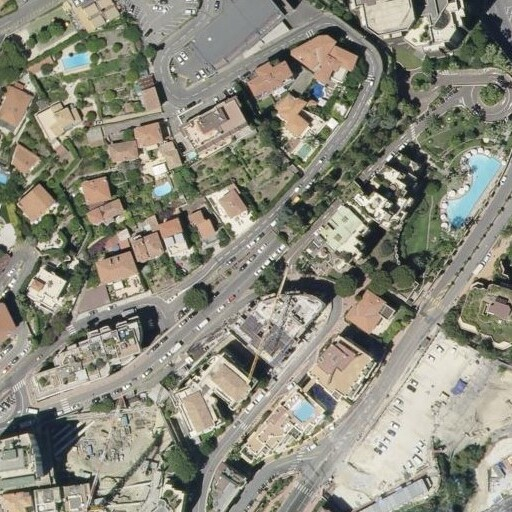

Analyzing test/test_1.jpg

 1 🎯 Detected pool = 0.9995	📦 left = 0.87 ⬆️ top = 0.30 ↔️ width = 0.11 ↕️ height = 0.15
 2 🎯 Detected pool = 0.9995	📦 left = 0.12 ⬆️ top = 0.10 ↔️ width = 0.07 ↕️ height = 0.04
 3 🎯 Detected pool = 0.9995	📦 left = 0.57 ⬆️ top = 0.78 ↔️ width = 0.05 ↕️ height = 0.05
 4 🎯 Detected pool = 0.9983	📦 left = 0.29 ⬆️ top = 0.35 ↔️ width = 0.05 ↕️ height = 0.04
 5 🎯 Detected pool = 0.9675	📦 left = 0.60 ⬆️ top = 0.15 ↔️ width = 0.04 ↕️ height = 0.05
 6 🎯 Detected pool = 0.9645	📦 left = 0.00 ⬆️ top = 0.33 ↔️ width = 0.02 ↕️ height = 0.04

✅ Annotated image saved to results/test_1.jpg


In [56]:
image_file = os.path.join(TEST_DIR, "test_1.jpg")

img = Image.open(image_file)
display(img)

output_image_file, predictions_list = get_predictions(project_id, publish_iteration_name, image_file, RESULTS_DIR)

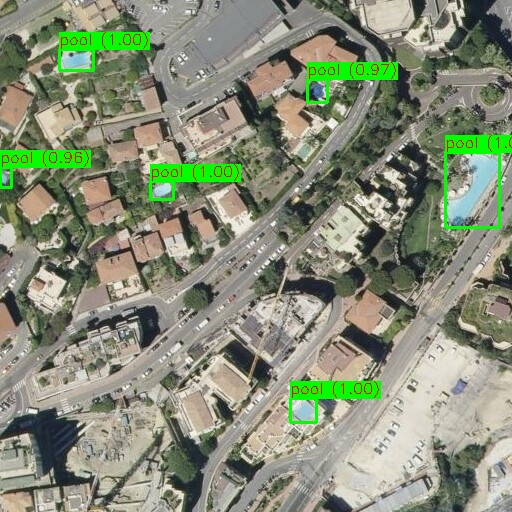

In [57]:
img = Image.open(output_image_file)
img

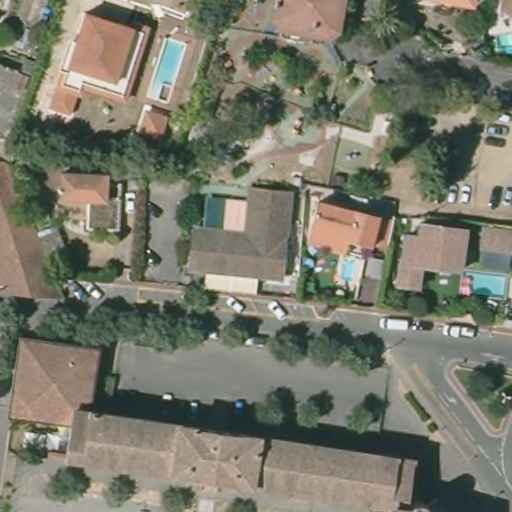

Analyzing test/test_2.jpg

 1 🎯 Detected pool = 0.9997	📦 left = 0.90 ⬆️ top = 0.52 ↔️ width = 0.09 ↕️ height = 0.07
 2 🎯 Detected pool = 0.9996	📦 left = 0.29 ⬆️ top = 0.07 ↔️ width = 0.08 ↕️ height = 0.13
 3 🎯 Detected pool = 0.9991	📦 left = 0.96 ⬆️ top = 0.05 ↔️ width = 0.04 ↕️ height = 0.06
 4 🎯 Detected pool = 0.9986	📦 left = 0.66 ⬆️ top = 0.50 ↔️ width = 0.04 ↕️ height = 0.06

✅ Annotated image saved to results/test_2.jpg


In [58]:
image_file = os.path.join(TEST_DIR, "test_2.jpg")

img = Image.open(image_file)
display(img)

output_image_file, predictions_list = get_predictions(project_id, publish_iteration_name, image_file, RESULTS_DIR)

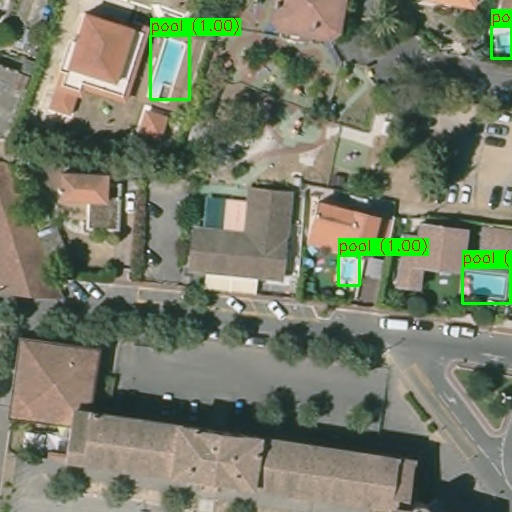

In [59]:
img = Image.open(output_image_file)
img

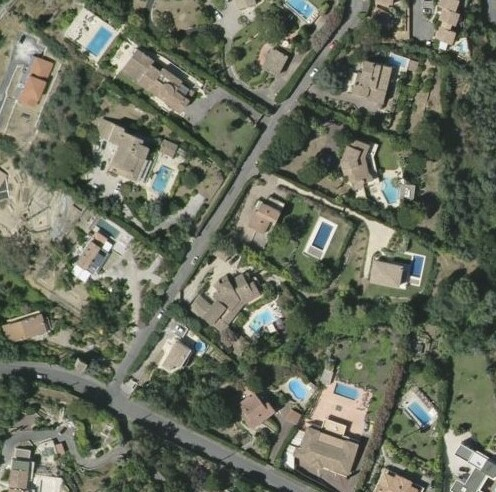

Analyzing test/test_3.jpg

 1 🎯 Detected pool = 0.9998	📦 left = 0.17 ⬆️ top = 0.05 ↔️ width = 0.07 ↕️ height = 0.07
 2 🎯 Detected pool = 0.9996	📦 left = 0.82 ⬆️ top = 0.80 ↔️ width = 0.06 ↕️ height = 0.07
 3 🎯 Detected pool = 0.9994	📦 left = 0.30 ⬆️ top = 0.33 ↔️ width = 0.06 ↕️ height = 0.07
 4 🎯 Detected pool = 0.9993	📦 left = 0.57 ⬆️ top = 0.00 ↔️ width = 0.07 ↕️ height = 0.04
 5 🎯 Detected pool = 0.9992	📦 left = 0.58 ⬆️ top = 0.76 ↔️ width = 0.05 ↕️ height = 0.05
 6 🎯 Detected pool = 0.9992	📦 left = 0.62 ⬆️ top = 0.44 ↔️ width = 0.06 ↕️ height = 0.08
 7 🎯 Detected pool = 0.999	📦 left = 0.76 ⬆️ top = 0.35 ↔️ width = 0.05 ↕️ height = 0.06
 8 🎯 Detected pool = 0.999	📦 left = 0.50 ⬆️ top = 0.62 ↔️ width = 0.07 ↕️ height = 0.06
 9 🎯 Detected pool = 0.9987	📦 left = 0.67 ⬆️ top = 0.77 ↔️ width = 0.07 ↕️ height = 0.04
10 🎯 Detected pool = 0.9913	📦 left = 0.77 ⬆️ top = 0.10 ↔️ width = 0.06 ↕️ height = 0.05
11 🎯 Detected pool = 0.9881	📦 left = 0.82 ⬆️ top = 0.51 ↔️ width = 0.04 ↕️ height = 0

In [60]:
image_file = os.path.join(TEST_DIR, "test_3.jpg")

img = Image.open(image_file)
display(img)

output_image_file, predictions_list = get_predictions(project_id, publish_iteration_name, image_file, RESULTS_DIR)

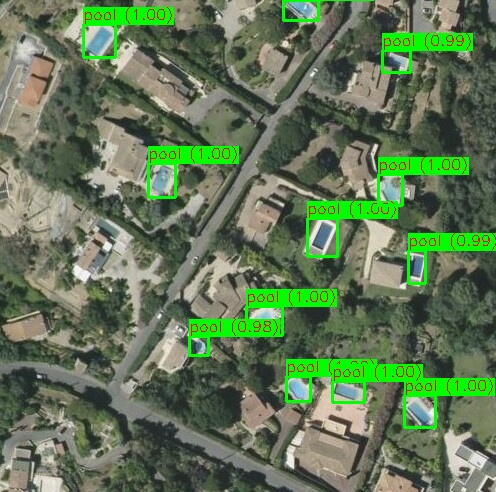

In [61]:
img = Image.open(output_image_file)
img

In [62]:
predictions_list

[{'tag': 'pool',
  'probability': 0.9997727,
  'bbox': {'left': 0.16910934,
   'top': 0.049869727,
   'width': 0.06577262,
   'height': 0.06860146}},
 {'tag': 'pool',
  'probability': 0.9996499,
  'bbox': {'left': 0.81545717,
   'top': 0.80466753,
   'width': 0.06425065,
   'height': 0.06587446}},
 {'tag': 'pool',
  'probability': 0.99940026,
  'bbox': {'left': 0.29978025,
   'top': 0.33140296,
   'width': 0.055343807,
   'height': 0.069664866}},
 {'tag': 'pool',
  'probability': 0.9992623,
  'bbox': {'left': 0.57065636,
   'top': 0.0006333637,
   'width': 0.07248998,
   'height': 0.04247074}},
 {'tag': 'pool',
  'probability': 0.99923813,
  'bbox': {'left': 0.5778329,
   'top': 0.7647462,
   'width': 0.050324798,
   'height': 0.05097395}},
 {'tag': 'pool',
  'probability': 0.9991768,
  'bbox': {'left': 0.620763,
   'top': 0.44383156,
   'width': 0.060997546,
   'height': 0.07801783}},
 {'tag': 'pool',
  'probability': 0.999,
  'bbox': {'left': 0.7633601,
   'top': 0.35415253,
   'widt

### 15. Batch

In [76]:
image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')

# Get all image files in the directory
image_files = [f for f in os.listdir(BATCH_DIR) if f.lower().endswith(image_extensions)]

In [77]:
batch_predictions = {}

for idx, image_file in enumerate(image_files, start=1):
    input_image_file = os.path.join(BATCH_DIR, image_file)
    print("-" * 100)
    print(f"{idx} Analyzing image file: {input_image_file}")
    print("-" * 100)
    # Get predictions
    output_image_file, predictions_list = get_predictions(project_id, publish_iteration_name, input_image_file, RESULTS_DIR)
    
    # Store both processed image and predictions in a dictionary
    batch_predictions[str(idx-1)] = {
        "processed": output_image_file,
        "predictions": predictions_list
    }
    
    print()

----------------------------------------------------------------------------------------------------
1 Analyzing image file: batch/image (1).jpg
----------------------------------------------------------------------------------------------------
Analyzing batch/image (1).jpg


✅ Annotated image saved to results/image (1).jpg

----------------------------------------------------------------------------------------------------
2 Analyzing image file: batch/image (10).jpg
----------------------------------------------------------------------------------------------------
Analyzing batch/image (10).jpg

 1 🎯 Detected pool = 0.9999	📦 left = 0.39 ⬆️ top = 0.57 ↔️ width = 0.10 ↕️ height = 0.15
 2 🎯 Detected pool = 0.9975	📦 left = 0.00 ⬆️ top = 0.87 ↔️ width = 0.06 ↕️ height = 0.08

✅ Annotated image saved to results/image (10).jpg

----------------------------------------------------------------------------------------------------
3 Analyzing image file: batch/image (11).jpg
-----------------

In [87]:
rows = []

for key, value in batch_predictions.items():
    image_file = value['processed']
    for pred in value['predictions']:
        row = {
            'image': image_file,
            'tag': pred['tag'],
            'probability': pred['probability'],
            'left': pred['bbox']['left'],
            'top': pred['bbox']['top'],
            'width': pred['bbox']['width'],
            'height': pred['bbox']['height']
        }
        rows.append(row)

df_predictions = pd.DataFrame(rows).sort_values(by='image')
df_predictions

image   tag  probability      left       top     width  \
0   results/image (10).jpg  pool     0.999860  0.389606  0.573665  0.096193   
1   results/image (10).jpg  pool     0.997511  0.001103  0.874055  0.055226   
2   results/image (11).jpg  pool     0.999926  0.305920  0.287457  0.144160   
3   results/image (11).jpg  pool     0.996386  0.799059  0.072411  0.147748   
4   results/image (12).jpg  pool     0.999849  0.825969  0.343103  0.164542   
5   results/image (12).jpg  pool     0.996778  0.378737  0.800370  0.144408   
6   results/image (12).jpg  pool     0.991479  0.002037  0.664148  0.124162   
7   results/image (12).jpg  pool     0.943736  0.418392  0.611866  0.044067   
8   results/image (12).jpg  pool     0.872769  0.489781  0.681968  0.034093   
9    results/image (3).jpg  pool     0.996963  0.456817  0.405453  0.074116   
10   results/image (3).jpg  pool     0.973862  0.302010  0.444517  0.061939   
11   results/image (3).jpg  pool     0.956477  0.401807  0.155265  0.025625   
12   results/image (3).jpg  pool     0.892945  0.744161  0.067528  0.042325   
13   results/image (4).jpg  pool     0.999747  0.469239  0.447016  0.073686   
15   results/image (5).jpg  pool     0.988234  0.074528  0.853366  0.031812   
14   results/image (5).jpg  pool     0.999782  0.586778  0.273894  0.154591   
16   results/image (6).jpg  pool     0.999837  0.438477  0.437106  0.121163   
17   results/image (6).jpg  pool     0.999578  0.503952  0.634239  0.155431   
18   results/image (6).jpg  pool     0.997893  0.562461  0.697479  0.407811   
19   results/image (7).jpg  pool     0.965229  0.475534  0.447563  0.070183   
20   results/image (8).jpg  pool     0.999728  0.450968  0.465239  0.095887   
21   results/image (8).jpg  pool     0.997698  0.599967  0.112823  0.031817   
22   results/image (8).jpg  pool     0.993984  0.000913  0.835766  0.053082   
23   results/image (8).jpg  pool     0.993282  0.069172  0.342512  0.057348   
24   results/image (8).jpg  pool     0.990494  0.054831  0.135058  0.049123   
25   results/image (8).jpg  pool     0.988593  0.165814  0.833551  0.033253   
26   results/image (8).jpg  pool     0.978121  0.284309  0.081235  0.028810   
27   results/image (8).jpg  pool     0.955792  0.569144  0.653617  0.037104   
28   results/image (9).jpg  pool     0.999684  0.452863  0.456747  0.068629   
29   results/image (9).jpg  pool     0.742175  0.456287  0.539184  0.047201   

      height  
0   0.153966  
1   0.082091  
2   0.080397  
3   0.091732  
4   0.125968  
5   0.090843  
6   0.097496  
7   0.040850  
8   0.042835  
9   0.175466  
10  0.100820  
11  0.023550  
12  0.079716  
13  0.091863  
15  0.040462  
14  0.174484  
16  0.121499  
17  0.138929  
18  0.278246  
19  0.071139  
20  0.070659  
21  0.035710  
22  0.033695  
23  0.047236  
24  0.033524  
25  0.052923  
26  0.041058  
27  0.037873  
28  0.085840  
29  0.039590

In [91]:
df_predictions['image'].value_counts(sort=True)

image
results/image (8).jpg     8
results/image (12).jpg    5
results/image (3).jpg     4
results/image (6).jpg     3
results/image (11).jpg    2
results/image (10).jpg    2
results/image (9).jpg     2
results/image (5).jpg     2
results/image (4).jpg     1
results/image (7).jpg     1
Name: count, dtype: int64

Analyzing image_08Oct2025_092815.jpg

 1 🎯 Detected pool = 0.9998	📦 left = 0.81 ⬆️ top = 0.05 ↔️ width = 0.13 ↕️ height = 0.13
 2 🎯 Detected pool = 0.9994	📦 left = 0.55 ⬆️ top = 0.10 ↔️ width = 0.05 ↕️ height = 0.05
 3 🎯 Detected pool = 0.9991	📦 left = 0.07 ⬆️ top = 0.74 ↔️ width = 0.06 ↕️ height = 0.05
 4 🎯 Detected pool = 0.9987	📦 left = 0.76 ⬆️ top = 0.33 ↔️ width = 0.09 ↕️ height = 0.06
 5 🎯 Detected pool = 0.9973	📦 left = 0.57 ⬆️ top = 0.55 ↔️ width = 0.07 ↕️ height = 0.05
 6 🎯 Detected pool = 0.9964	📦 left = 0.21 ⬆️ top = 0.56 ↔️ width = 0.06 ↕️ height = 0.04
 7 🎯 Detected pool = 0.992	📦 left = 0.69 ⬆️ top = 0.77 ↔️ width = 0.04 ↕️ height = 0.04
 8 🎯 Detected pool = 0.8862	📦 left = 0.50 ⬆️ top = 0.31 ↔️ width = 0.05 ↕️ height = 0.03

✅ Annotated image saved to results/image_08Oct2025_092815.jpg
Analyzing image_08Oct2025_094008.jpg

 1 🎯 Detected pool = 0.9997	📦 left = 0.90 ⬆️ top = 0.52 ↔️ width = 0.10 ↕️ height = 0.07
 2 🎯 Detected pool = 0.9996	📦 left = 0.29 ⬆️ top = 0.07 ↔️ wi

In [89]:
# Save to Excel
excel_file = os.path.join(RESULTS_DIR, "batch_predictions.xlsx")
df_predictions.to_excel(excel_file, index=False)

print(f"Saving results into '{excel_file}'")
!ls $excel_file -lh

Saving results into 'results/batch_predictions.xlsx'
-rwxrwxrwx 1 root root 6.6K Oct  8 09:23 results/batch_predictions.xlsx


In [81]:
link = FileLink(path=excel_file)
link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Azure AI Custom Vision OD/results/batch_predictions.xlsx

## 16. Gradio webapp

In [103]:
def gradio_fn(image, min_pred):
    """
    Process uploaded image and return predictions
    
    Args:
        image: PIL Image or file path from Gradio
    
    Returns:
        tuple: (output_file_path, predictions_text)
    """
    try:
        # Save uploaded image temporarily if needed
        start = time.time()
        
        if hasattr(image, 'save'):
            now = datetime.today().strftime('%d%b%Y_%H%M%S')
            temp_path = f"image_{now}.jpg"
            image.save(temp_path)
            image_file = temp_path
        else:
            image_file = image

        # Call your prediction function
        output_file, predictions_list = get_predictions(project_id, publish_iteration_name, image_file, RESULTS_DIR, min_pred)

        # Clean up temp file if created
        if 'temp_path' in locals() and os.path.exists(temp_path):
            os.remove(temp_path)

        nb_pools = len(predictions_list)
        output = f"{'Tag':<6} {'Probability':<12} {'Bounding Box (Left, Top, Width, Height)'}\n\n"

        for detection in predictions_list:
            tag = detection['tag']
            prob = round(detection['probability'], 4)
            bbox = detection['bbox']
            bbox_str = f"({bbox['left']:.4f}, {bbox['top']:.4f}, {bbox['width']:.4f}, {bbox['height']:.4f})"
            output += f"{tag:<6} {prob:<12} {bbox_str}\n"

        elapsed = time.time() - start
        now = datetime.today().strftime('%d-%b-%Y %H:%M:%S')
        elapsed_str = f"[{now}] Processed in {elapsed:.3f} seconds"
        
        return output_file, nb_pools, output, elapsed_str

    except Exception as e:
        error_msg = f"Error processing image: {str(e)}"
        return None, error_msg

In [104]:
def create_gradio_app():
    """Create and configure the Gradio interface"""

    with gr.Blocks(title="Object Detection App",
                   theme=gr.themes.Soft()) as app:
        gr.Markdown("# 🏊 Swimming pool detection with Azure AI Custom Vision")
        gr.Markdown("🖼️ Upload an image to get predictions")

        with gr.Row():
            with gr.Column(scale=1):
                # Input section
                gr.Markdown("### Input")
                image_input = gr.Image(type="pil",
                                       label="⬆️ Upload Image",
                                       height=500)

                min_pred_slider = gr.Slider(
                    minimum=0.0,
                    maximum=1.0,
                    value=0.8,
                    step=0.05,
                    label="Minimum Prediction Threshold",
                    info="Lower values detect more objects but may include false positives"
                )
                
                submit_btn = gr.Button("DETECT", variant="primary", size="lg")
                
            with gr.Column(scale=1):
                # Output section
                gr.Markdown("### 🖥️ Azure AI Custom Vision model results")
                output_image = gr.Image(label="🖼️ Processed image", height=500)
                nb_pools = gr.Textbox(
                    label="🏊 Number of detected swimming pools",
                    lines=1,
                    max_lines=1,
                    interactive=False)

                predictions_list = gr.Textbox(label="Details",
                                              lines=10,
                                              max_lines=20,
                                              interactive=False)
                
                elapsed_str = gr.Textbox(label="Elapsed",
                                         lines=1,
                                         interactive=False)
        
        gr.Examples(
            examples=[
                "test/test_1.jpg",
                "test/test_2.jpg",
                "test/test_3.jpg",
                "test/test_4.jpg" ,
                "test/test_5.jpg",
            ],
            inputs=[image_input],
            label="📂 Some images"
        )

        # Event handlers
        submit_btn.click(fn=gradio_fn,
                         inputs=[image_input, min_pred_slider],
                         outputs=[output_image, nb_pools, predictions_list, elapsed_str],
                         show_progress=True)

    return app

In [105]:
webapp = create_gradio_app()
webapp.launch(share=True)

2025-10-08 09:49:21,214 - INFO - HTTP Request: GET http://127.0.0.1:7863/gradio_api/startup-events "HTTP/1.1 200 OK"
2025-10-08 09:49:21,224 - INFO - HTTP Request: HEAD http://127.0.0.1:7863/ "HTTP/1.1 200 OK"
2025-10-08 09:49:21,327 - INFO - HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


* Running on local URL:  http://127.0.0.1:7863


2025-10-08 09:49:21,940 - INFO - HTTP Request: GET https://api.gradio.app/v3/tunnel-request "HTTP/1.1 200 OK"


* Running on public URL: https://67a467cd5b2ddd9899.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


2025-10-08 09:49:23,584 - INFO - HTTP Request: HEAD https://67a467cd5b2ddd9899.gradio.live "HTTP/1.1 200 OK"


Analyzing image_08Oct2025_094931.jpg

 1 🎯 Detected pool = 0.9998	📦 left = 0.17 ⬆️ top = 0.05 ↔️ width = 0.07 ↕️ height = 0.07
 2 🎯 Detected pool = 0.9996	📦 left = 0.82 ⬆️ top = 0.80 ↔️ width = 0.06 ↕️ height = 0.07
 3 🎯 Detected pool = 0.9993	📦 left = 0.62 ⬆️ top = 0.44 ↔️ width = 0.06 ↕️ height = 0.08
 4 🎯 Detected pool = 0.9993	📦 left = 0.30 ⬆️ top = 0.33 ↔️ width = 0.06 ↕️ height = 0.07
 5 🎯 Detected pool = 0.999	📦 left = 0.57 ⬆️ top = 0.00 ↔️ width = 0.07 ↕️ height = 0.04
 6 🎯 Detected pool = 0.999	📦 left = 0.58 ⬆️ top = 0.76 ↔️ width = 0.05 ↕️ height = 0.05
 7 🎯 Detected pool = 0.9989	📦 left = 0.50 ⬆️ top = 0.62 ↔️ width = 0.07 ↕️ height = 0.06
 8 🎯 Detected pool = 0.9988	📦 left = 0.76 ⬆️ top = 0.35 ↔️ width = 0.05 ↕️ height = 0.07
 9 🎯 Detected pool = 0.9987	📦 left = 0.67 ⬆️ top = 0.77 ↔️ width = 0.07 ↕️ height = 0.04
10 🎯 Detected pool = 0.9865	📦 left = 0.82 ⬆️ top = 0.51 ↔️ width = 0.04 ↕️ height = 0.07
11 🎯 Detected pool = 0.9445	📦 left = 0.77 ⬆️ top = 0.10 ↔️ width = 0.06 ↕️